In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage.feature import hog, match_template
from skimage import data, exposure
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from time import time
from shutil import copyfile
print("Packages Loaded")

Packages Loaded


In [2]:
##############################################################################################
#######################  Load Images  ########################################################
##############################################################################################
tic = time()

# File locations
excel_file = r"cars_classes.xlsx"
train_folder = r"cars_train\cars_train"
test_folder = r"cars_test\cars_test"
output_folder = r"cars_dataset"  # Folder for the combined dataset
excel_out = r"cars_classes_split.xlsx"

In [3]:
# Load training data
train_df = pd.read_excel(excel_file, sheet_name='train')

# Load testing data
test_df = pd.read_excel(excel_file, sheet_name='test')

In [4]:
# Function to label and copy images
def label_and_copy(df, image_folder, output_folder):
    for index, row in df.iterrows():
        image_name = row['image']  # Assuming 'image_name' column exists
        true_class_name = row['true_class_name']
        class_name = true_class_name.split()[0]
        source_path = os.path.join(image_folder, image_name)
        destination_path = os.path.join(output_folder, class_name, image_name)
        os.makedirs(os.path.join(output_folder, class_name), exist_ok=True)  # Create class folders
        copyfile(source_path, destination_path)

#label_and_copy(train_df, train_folder, output_folder)# Label and copy training images
#label_and_copy(test_df, test_folder, output_folder)# Label and copy testing images

def create_filtered_dataframe(dataset_path, brands):
  """
  Creates a Pandas DataFrame from a dataset folder,
  filtering for specific brands.

  Args:
    dataset_path: Path to the dataset folder.
    brands: List of brands to include.

  Returns:
    A Pandas DataFrame with image paths and labels.
  """

  data = []
  for brand in brands:
    brand_folder = os.path.join(dataset_path, brand)
    if os.path.isdir(brand_folder):
      for image_name in os.listdir(brand_folder):
        image_path = os.path.join(brand_folder, image_name)
        # image = cv2.imread(image_path)
        data.append({'image_path': image_path, 'brand': brand}) # 'image':image
  return pd.DataFrame(data)

In [5]:
# Specify the dataset path and desired brands
selected_brands = ['Chevrolet', 'BMW', 'Dodge', 'Audi']

# Create the filtered DataFrame
filtered_df = create_filtered_dataframe(output_folder, selected_brands)

# Display the DataFrame (optional)
filtered_df.head()

# Split the DataFrame into training and testing sets
train_df, test_df = train_test_split(filtered_df, test_size=0.3, random_state=42,stratify=filtered_df['brand'])

# Save the New DataFrames to the same xlsx files with two sheets
#with pd.ExcelWriter(excel_out) as writer:
#    train_df.to_excel(writer, sheet_name='train', index=False)
#    test_df.to_excel(writer, sheet_name='test', index=False)

print("Images Copied and Split in: ", time()-tic)

Images Copied and Split in:  15.635181665420532


In [6]:
# For each image in train_df load in the image and resize the image to 224x224
# Convert the image to a numpy array in RGP format
def load_jpg(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Crop image so that it is square (DONT CHANGE ASPECT RATIO)
    h, w, _ = img.shape
    if h > w:
        img = img[(h-w)//2:(h+w)//2, :]
    else:
        img = img[:, (w-h)//2:(w+h)//2]
    img = cv2.resize(img, (224, 224))
    return img

def load_images(df):
    images = []
    Y = []
    for index, row in df.iterrows():
        img = load_jpg(row["image_path"])
        images.append(img)
        Y.append(row["brand"])
    return images, Y

train_images, targets = load_images(train_df)
test_images, labels = load_images(test_df)

In [7]:
print(len(train_images))
print(len(test_images))

3530
1513


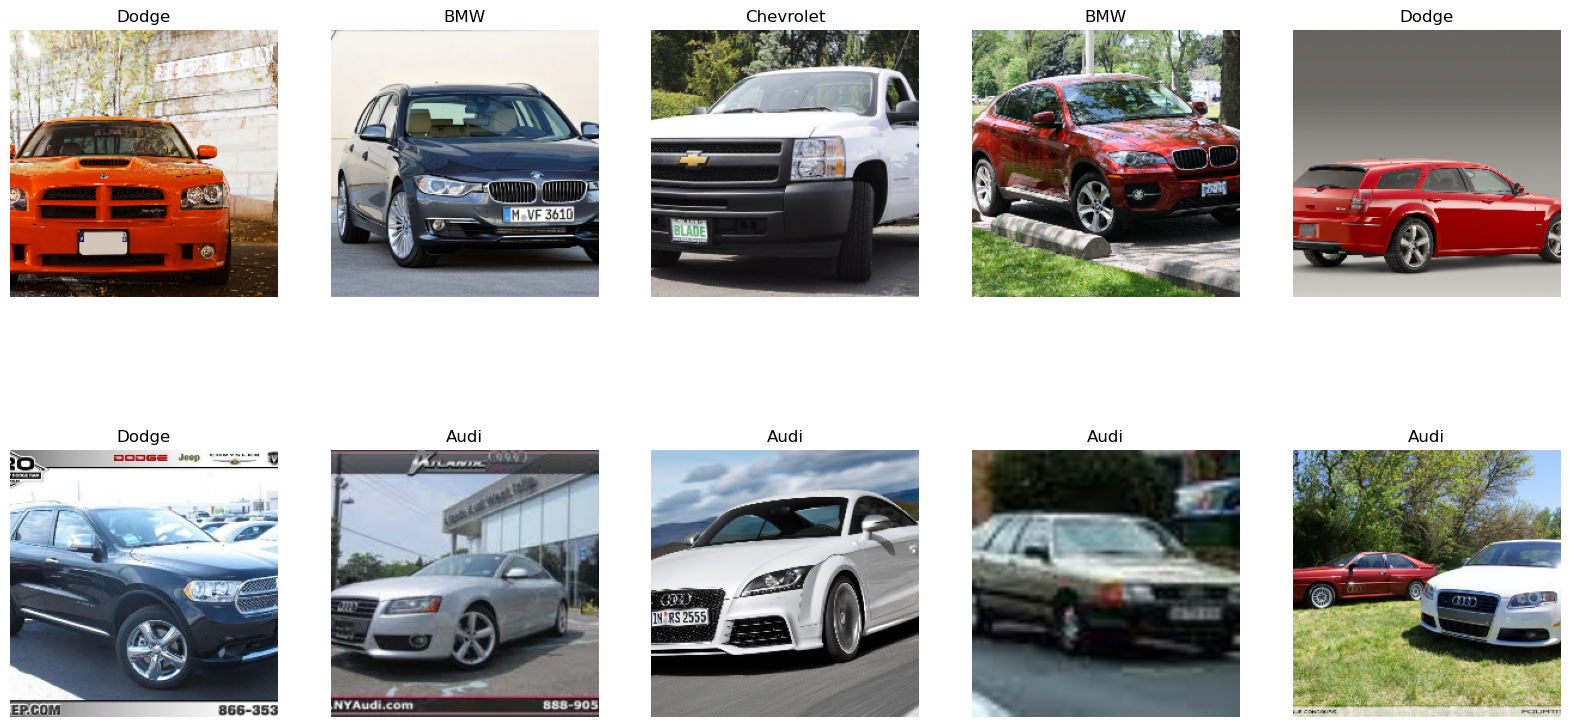

Images Loaded in:  77.76514387130737


In [8]:
# Plot the Images and their labels
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[i])
    plt.title(targets[i])
    plt.axis('off')
plt.show()

print("Images Loaded in: ", time()-tic)

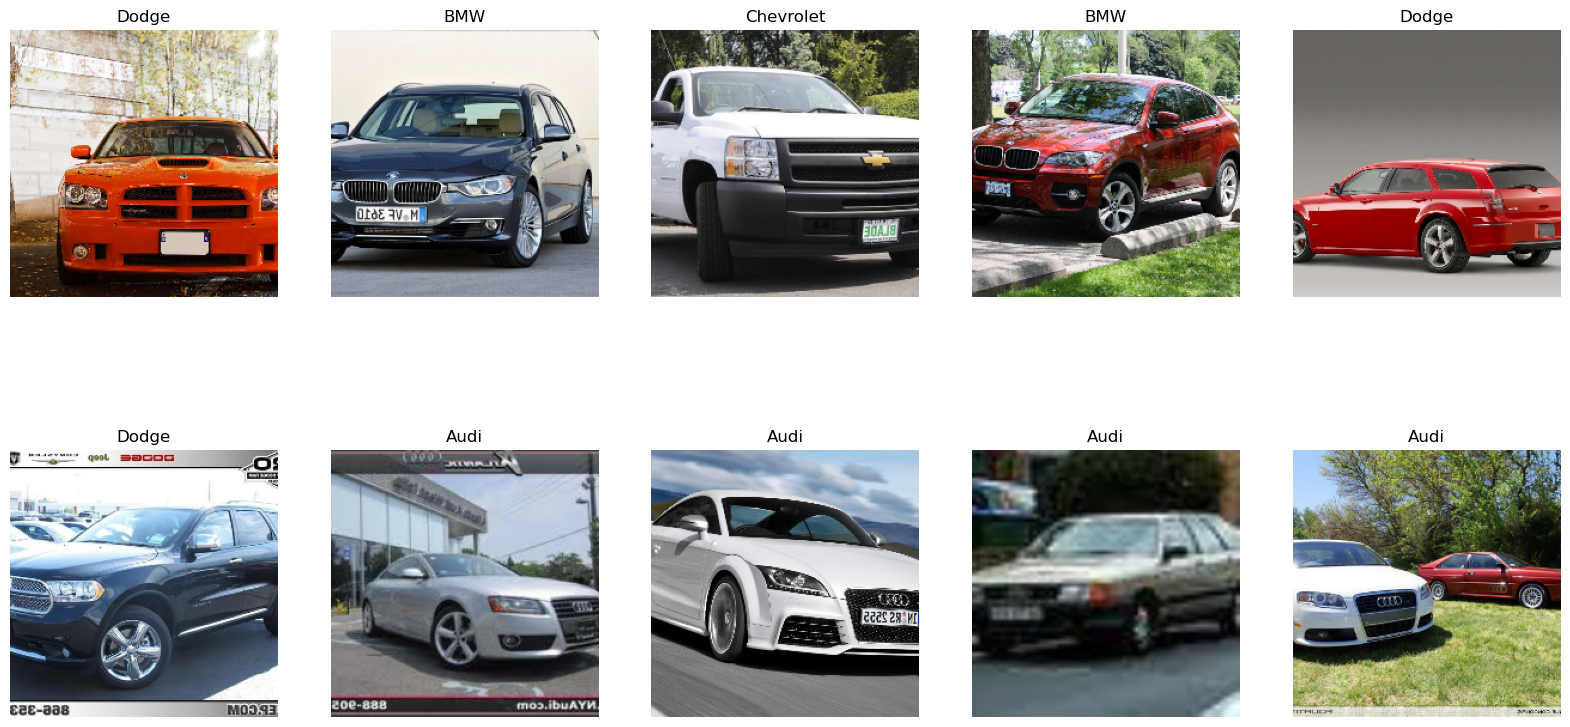

Images Augmented in:  0.8114290237426758


In [8]:
##############################################################################################
#######################  Augment Images  #####################################################
##############################################################################################
tic = time()

def augment_images(images, targets):
    # OKAY TO FLIP IMAGES, but rotations and shearing will cause misalignment and probably not help blind
    # Missaligned edges (black space) a problem downstream? YES
    augmented_images = []
    augmented_target = []
    for i in range(len(images)):
        img = images[i]
        img = cv2.flip(img, 1)
        ### Consider Adding Contrast Normalization if the training data isn't large enough
        augmented_images.append(img)
        augmented_target.append(targets[i])
    return augmented_images, augmented_target

# # Plot the Augmented Images and their labels
augmented_images, augmented_targets = augment_images(train_images, targets)

plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(augmented_images[i])
    plt.title(augmented_targets[i])
    plt.axis('off')
plt.show()

train_images.extend(augmented_images)
targets.extend(augmented_targets)

print("Images Augmented in: ", time()-tic)

In [13]:
print(train_images[0].size)
print(test_images[0].size)

150528
150528


TypeError: Invalid shape (1568,) for image data

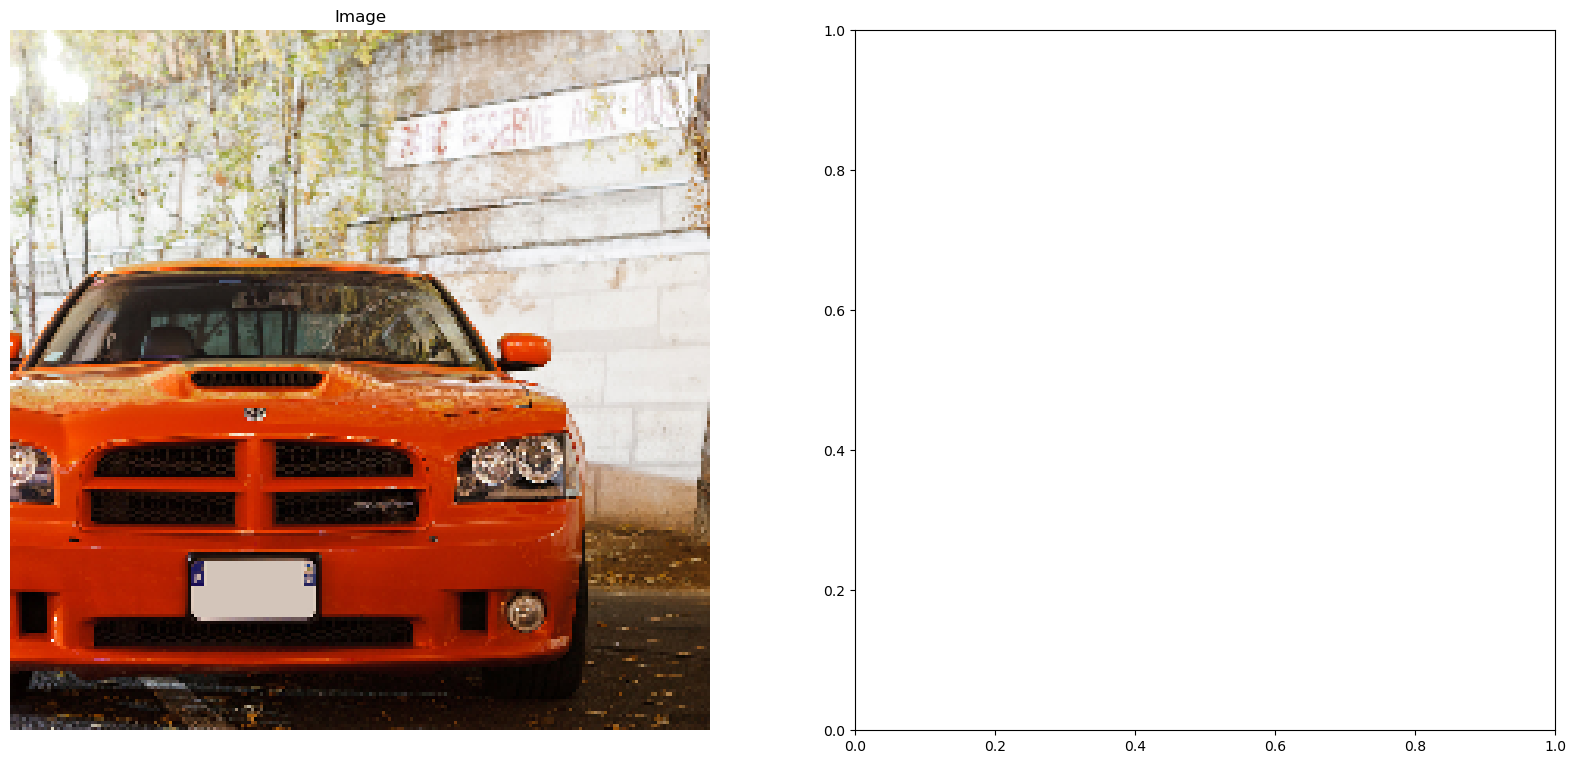

In [9]:
##############################################################################################
#######################  Feature Building ####################################################
##############################################################################################
'''
HOG transform, Forrier Transform, and Canny Edge Detect on images, save features as seperate Arrays
'''
tic = time()

def hog_features(images):
    hog_features = []
    for img in images:
        #fd, hog_feature = hog(img, orientations=8, pixels_per_cell=(16, 16), visualize=True,
        #                   cells_per_block=(1, 1), channel_axis=-1) # Uncomment to viusalize HOG feature
        hog_feature = hog(img, orientations=8, pixels_per_cell=(16, 16),
                           cells_per_block=(1, 1), channel_axis=-1)
        #hog_image_rescaled = exposure.rescale_intensity(hog_feature, in_range=(0, 10))
        hog_features.append(hog_feature)
    return hog_features

def fourier_features(images):
    fourier_features = []
    [ydim, xdim, zdim] = images[0].shape
    win = np.outer(np.hanning(ydim), np.hanning(xdim))
    win = win / np.mean(win)
    for img in images:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        F = np.fft.fftshift(np.fft.fft2(gray_img*win))
        Fmag = np.abs(F)
        fourier_features.append(Fmag)
    return fourier_features

def canny_features(images):
    canny_features = []
    for img in images:
        canny = cv2.Canny(img, 100, 200)
        canny_features.append(canny)
    return canny_features

train_hog = hog_features(train_images)
train_fourier = fourier_features(train_images)
train_canny = canny_features(train_images)

test_hog = hog_features(test_images)
test_fourier = fourier_features(test_images)
test_canny = canny_features(test_images)

for i in range(20):
    # plot the image, hog, fourier, and canny
    plt.figure(figsize=(20,20))
    plt.subplot(2, 2, 1)
    plt.imshow(train_images[i])
    plt.title("Image")
    plt.axis('off')
    plt.subplot(2, 2, 2)
    plt.imshow(train_hog[i], cmap='gray')
    plt.title("HOG")
    plt.axis('off')
    plt.subplot(2, 2, 3)
    plt.imshow(np.log(train_fourier[i]), cmap='gray')
    plt.title("Fourier")
    plt.axis('off')
    plt.subplot(2, 2, 4)
    plt.imshow(train_canny[i], cmap='gray')
    plt.title("Canny")
    plt.axis('off')
    plt.show()

print("Features Built in: ", time()-tic)

In [19]:
print(train_canny[0].shape)

(224, 224)


C:\Users\jcf03\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\jcf03\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


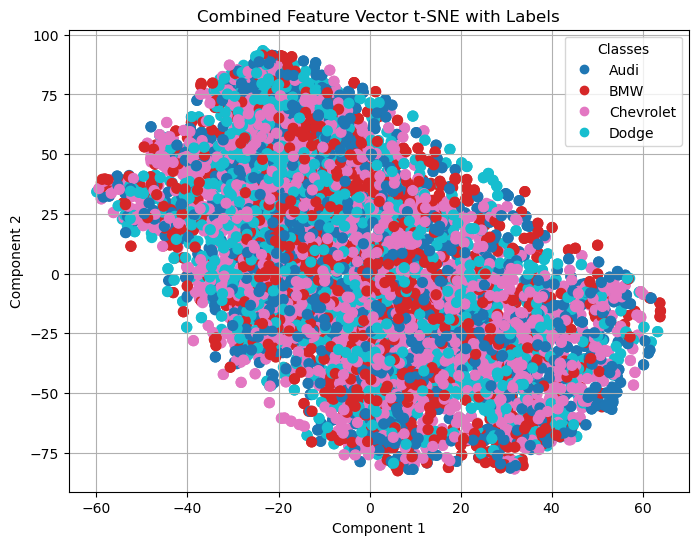

In [16]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(train_concat_features)

le = LabelEncoder()
numeric_labels = le.fit_transform(targets)
label_names = le.classes_

plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=numeric_labels, cmap='tab10', s=50)
handles, indices = scatter.legend_elements()
legend_labels = [label_names[i] for i in range(len(handles))]
plt.legend(handles, legend_labels, title="Classes")
plt.title("Combined Feature Vector t-SNE with Labels")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

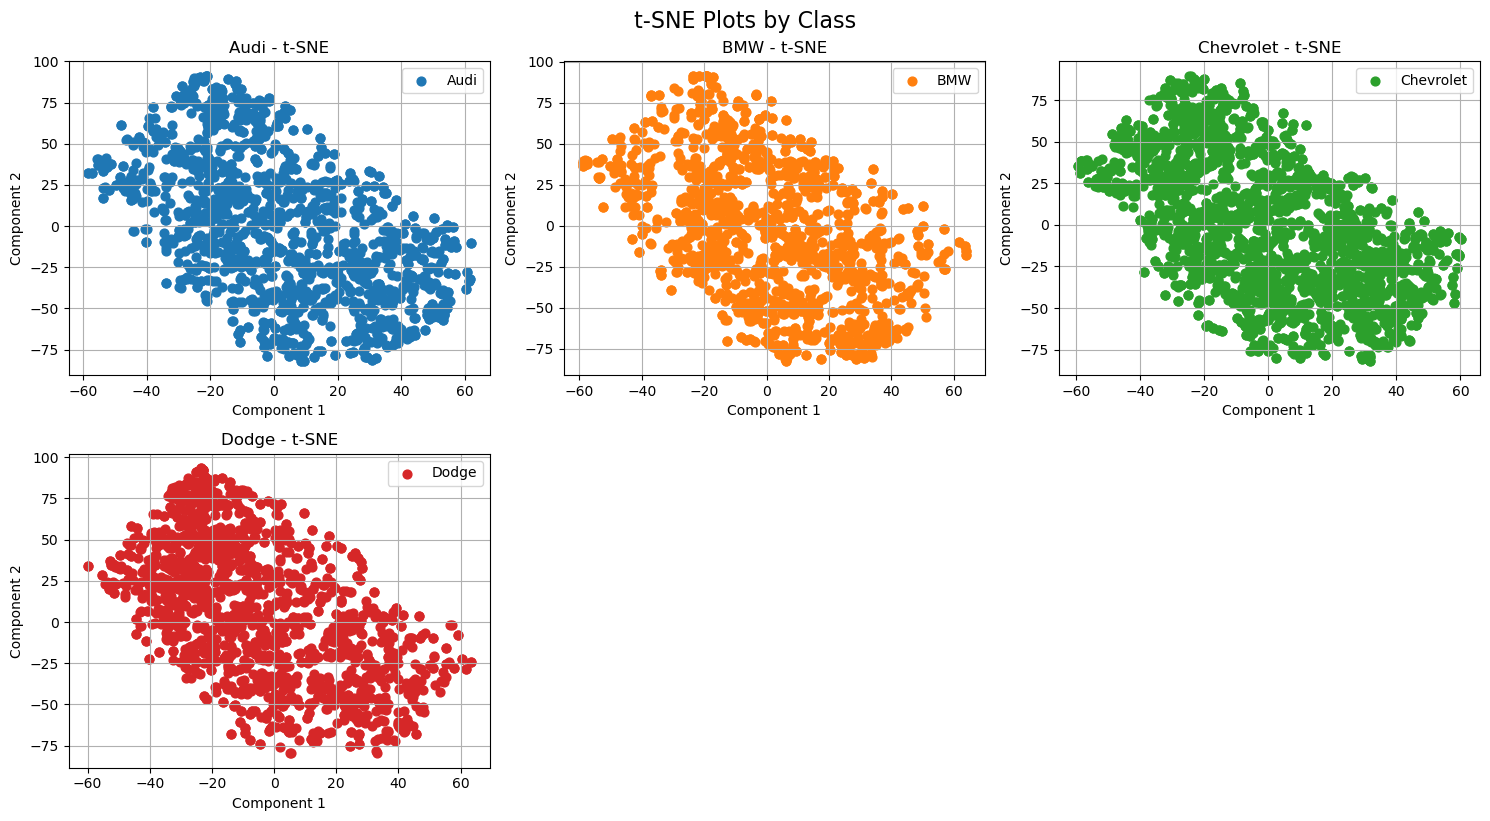

In [18]:
# Set up the figure
num_classes = len(label_names)
cols = 3
rows = int(np.ceil(num_classes / cols))
plt.figure(figsize=(cols * 5, rows * 4))

# Create a subplot for each label
for i, label in enumerate(label_names):
    plt.subplot(rows, cols, i + 1)
    mask = numeric_labels == i
    plt.scatter(tsne_results[mask, 0], tsne_results[mask, 1],
                c=[plt.cm.tab10(i)], label=label, s=40)
    plt.title(f"{label} - t-SNE")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle("t-SNE Plots by Class", fontsize=16, y=1.02)
plt.show()

C:\Users\jcf03\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


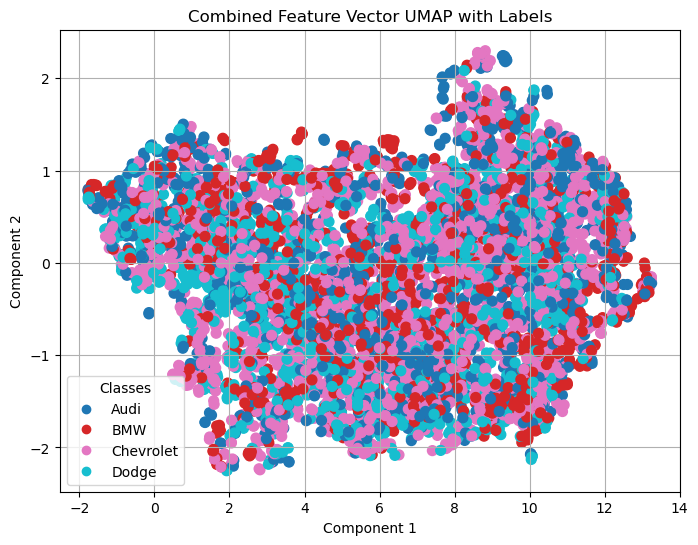

In [17]:
import umap.umap_ as umap

# Fit UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_results = umap_model.fit_transform(train_concat_features)

# Encode labels
le = LabelEncoder()
numeric_labels = le.fit_transform(targets)
label_names = le.classes_

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(umap_results[:, 0], umap_results[:, 1], c=numeric_labels, cmap='tab10', s=50)
handles, indices = scatter.legend_elements()
legend_labels = [label_names[i] for i in range(len(handles))]
plt.legend(handles, legend_labels, title="Classes")
plt.title("Combined Feature Vector UMAP with Labels")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

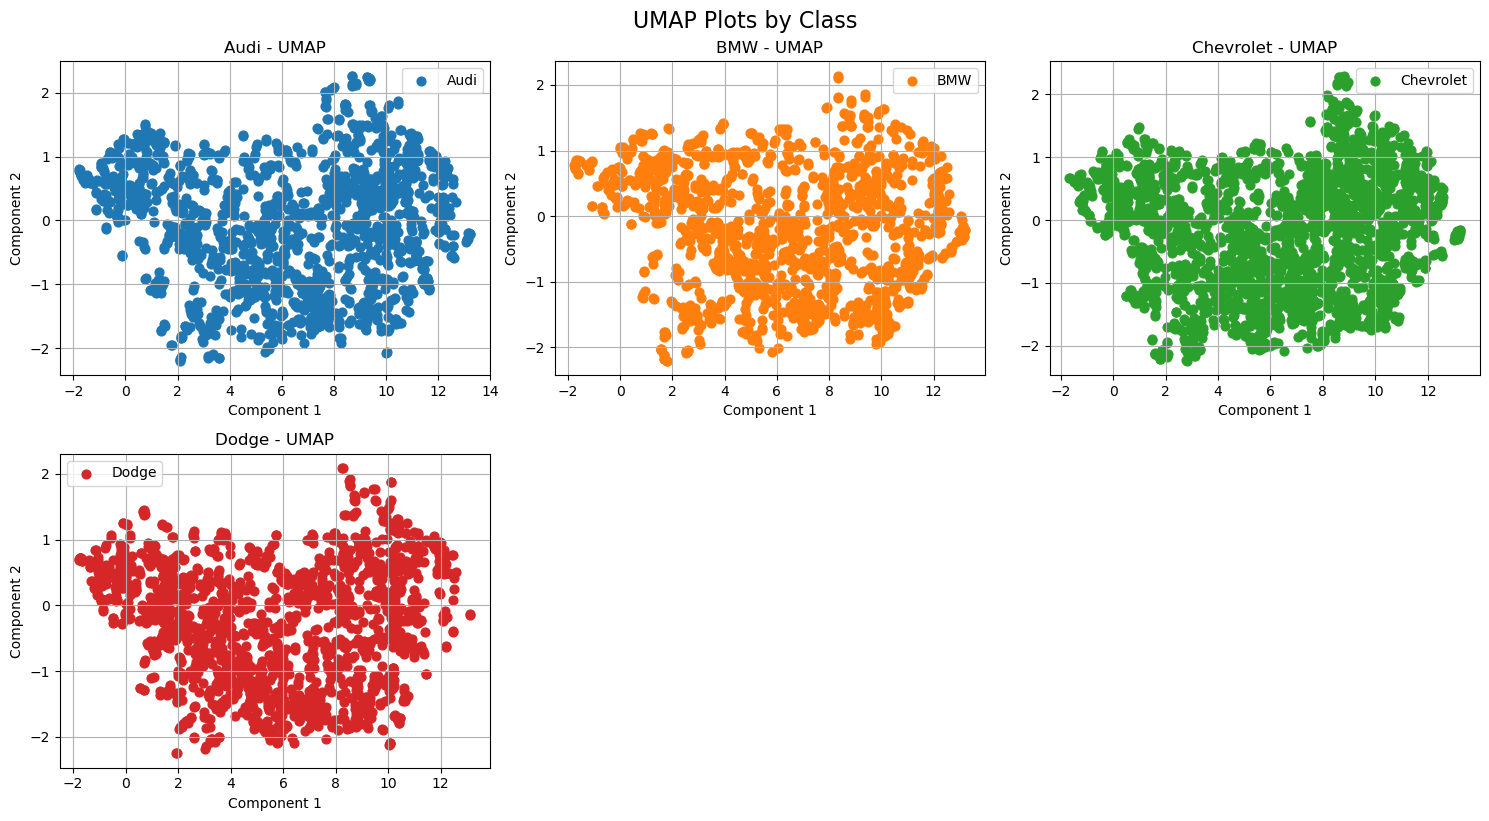

In [19]:
# Set up the figure
num_classes = len(label_names)
cols = 3
rows = int(np.ceil(num_classes / cols))
plt.figure(figsize=(cols * 5, rows * 4))

# Create a subplot for each label
for i, label in enumerate(label_names):
    plt.subplot(rows, cols, i + 1)
    mask = numeric_labels == i
    plt.scatter(umap_results[mask, 0], umap_results[mask, 1],
                c=[plt.cm.tab10(i)], label=label, s=40)
    plt.title(f"{label} - UMAP")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle("UMAP Plots by Class", fontsize=16, y=1.02)
plt.show()

In [13]:
##############################################################################################
############################ Flatten and Stack Features Images ###############################
##############################################################################################
# Flatten all features into a single row
tic = time()
def stack_rows(features):
    '''
    Efficiently stacks multiple lists of image features row-wise.
    For each image i, flattens all features and concatenates them into a single row.
    Returns a 2D numpy array.
    '''
    stacked = np.array([
        np.concatenate([feature[i].flatten() for feature in features])
        for i in range(len(features[0]))
    ])
    return stacked


stacked_features = stack_rows([hog, fourier, canny])

print("Features Stacked in: ", time()-tic)

Features Stacked in:  1.3508775234222412


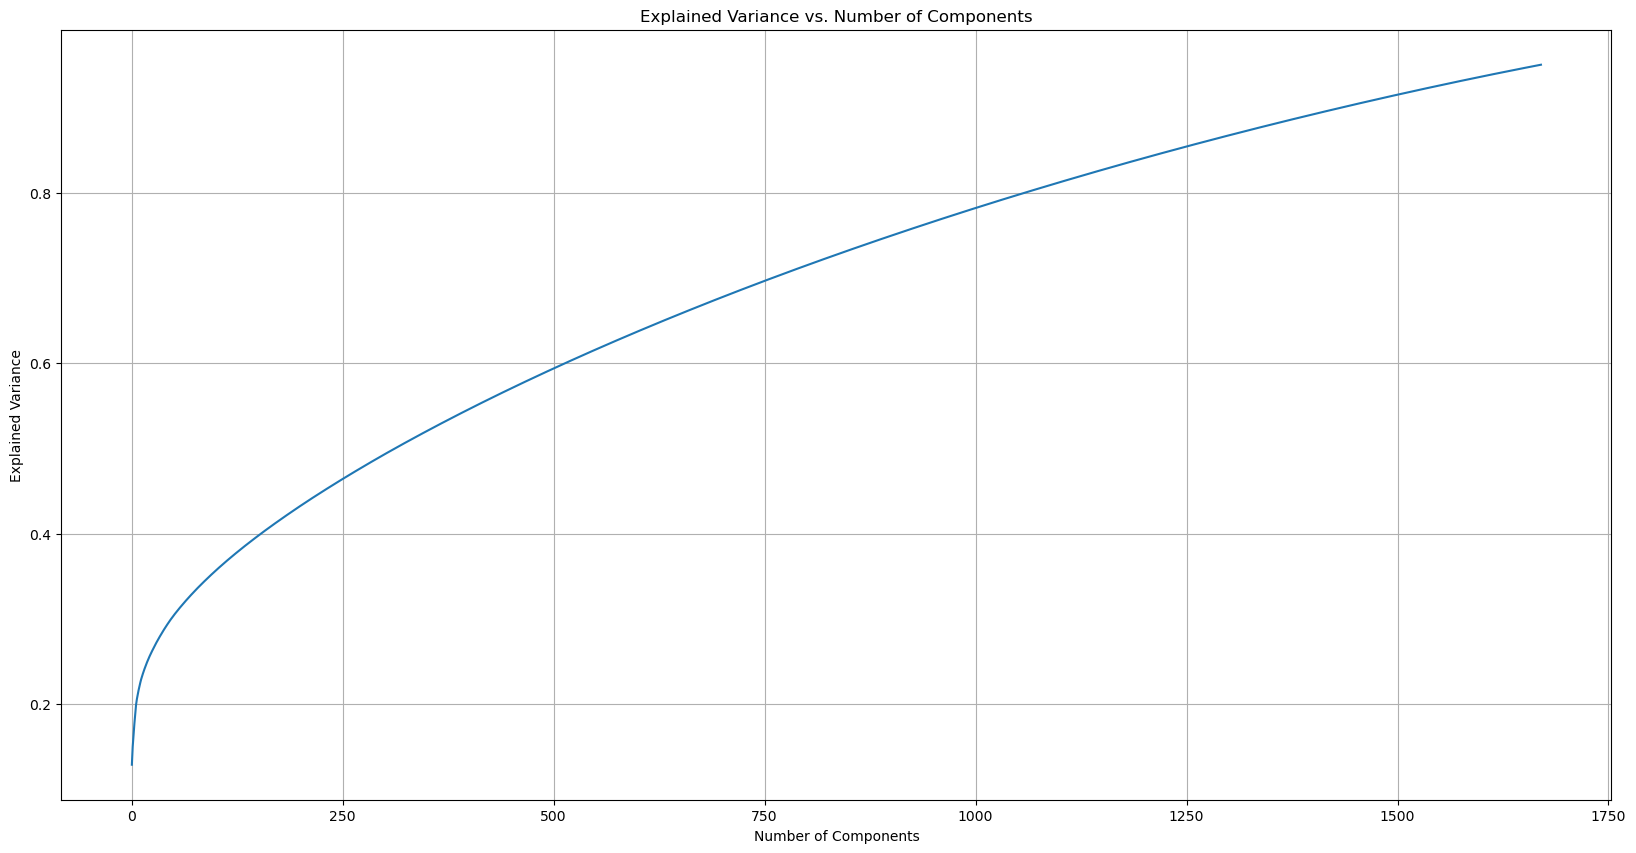

PCA Completed in:  59.72053861618042


In [14]:
##############################################################################################
################################ Principal Component Analysis ################################
##############################################################################################
tic = time()

# Normalize the stacked features
from sklearn.preprocessing import StandardScaler
stacked_features = StandardScaler().fit_transform(stacked_features)

# Run PCA on the stacked features
pca = PCA(n_components=0.95)
pca.fit(stacked_features)
X = pca.transform(stacked_features)

# Plot the explained variance
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

print("PCA Completed in: ", time()-tic)

In [32]:
print(train_canny[0].shape)

(224, 224)


In [12]:
train_flattened_fourier = np.array([img.flatten() for img in train_fourier])
train_flattened_canny = np.array([img.flatten() for img in train_canny])

test_flattened_fourier = np.array([img.flatten() for img in test_fourier])
test_flattened_canny = np.array([img.flatten() for img in test_canny])

In [15]:
train_concat_features = np.concatenate((train_hog, train_flattened_fourier, train_flattened_canny), axis=1)
test_concat_features = np.concatenate((test_hog, test_flattened_fourier, test_flattened_canny), axis=1)

In [36]:
print(train_concat_features.shape)

(7060, 101920)


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

#X = train_concat_features.reshape(train_concat_features.shape[0], -1)
#Y = test_concat_features.reshape(test_concat_features.shape[0], -1)

# Optional: Split into training and validation sets
#X_train, X_val, y_train, y_val = train_test_split(
#    X, targets, test_size=0.2, random_state=42
#)

# Initialize and train logistic regression model
clf = LogisticRegression(max_iter=5000, solver='lbfgs')  # increase max_iter if needed
clf.fit(train_concat_features, targets)

# Predict on validation set
y_pred = clf.predict(test_concat_features)

# Evaluate
print("Accuracy:", accuracy_score(labels, y_pred))
print("\nClassification Report:\n", classification_report(labels, y_pred))

Accuracy: 0.3707865168539326

Classification Report:
               precision    recall  f1-score   support

        Audi       0.35      0.36      0.36       337
         BMW       0.31      0.31      0.31       307
   Chevrolet       0.45      0.44      0.45       508
       Dodge       0.33      0.34      0.33       361

    accuracy                           0.37      1513
   macro avg       0.36      0.36      0.36      1513
weighted avg       0.37      0.37      0.37      1513



Text(0.5, 427.9555555555555, 'Predicted Label')

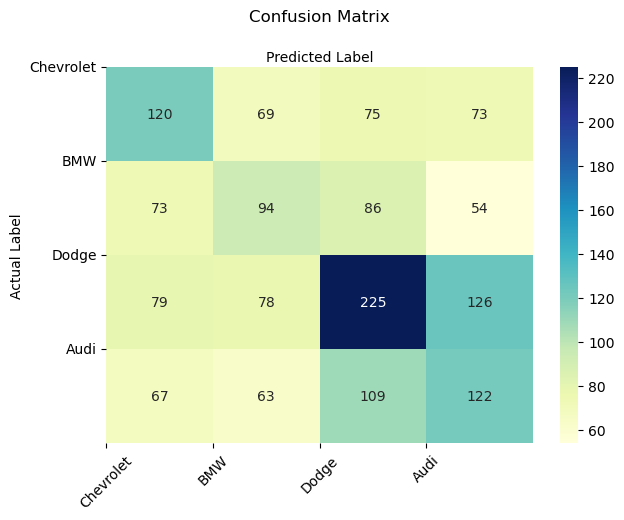

In [44]:
# import the metrics class
from sklearn import metrics
import seaborn as sns

cnf_matrix = metrics.confusion_matrix(labels, y_pred)

cnf_df = pd.DataFrame(cnf_matrix, index=selected_brands, columns=selected_brands)

fig, ax = plt.subplots()
tick_marks = np.arange(len(selected_brands))
plt.xticks(tick_marks, selected_brands)
plt.yticks(tick_marks, selected_brands)
# create heatmap
sns.heatmap(cnf_df, annot=True, cmap="YlGnBu", fmt='g')

# Set tick labels
tick_marks = np.arange(len(selected_brands))
plt.xticks(tick_marks, selected_brands, rotation=45)
plt.yticks(tick_marks, selected_brands, rotation=0)

# Labels and layout
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

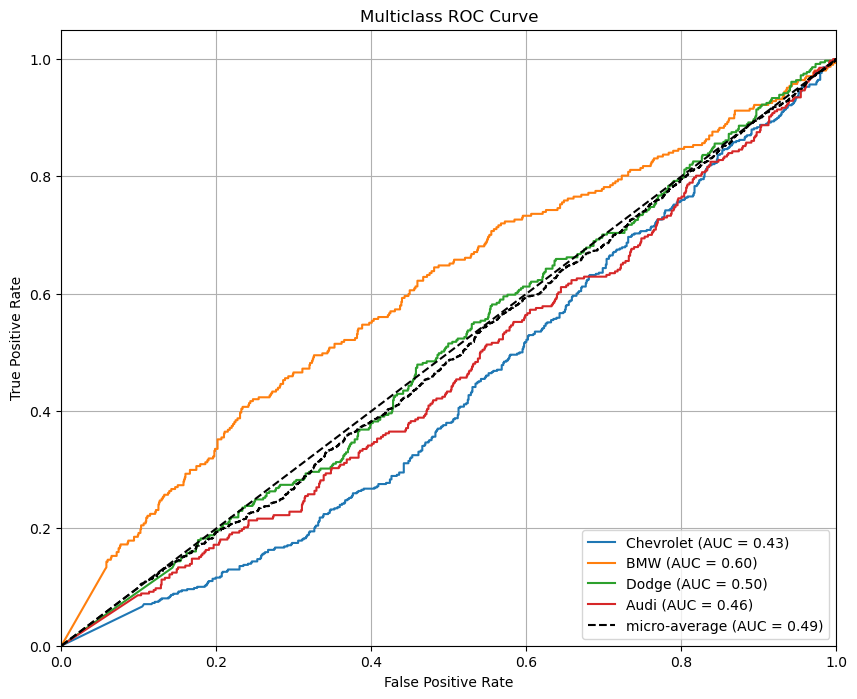

In [45]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Step 1: Binarize the labels
y_val_bin = label_binarize(labels, classes=selected_brands)
n_classes = y_val_bin.shape[1]

# Step 2: Get predicted probabilities for each class
y_pred_proba = clf.predict_proba(test_concat_features)

# Step 3: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Optional: Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Step 4: Plot all ROC curves
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{selected_brands[i]} (AUC = {roc_auc[i]:.2f})')

# Optional: micro-average curve
plt.plot(fpr["micro"], tpr["micro"], 
         label=f'micro-average (AUC = {roc_auc["micro"]:.2f})', linestyle='--', color='black')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [46]:
# Display the DataFrame (optional)
print(len(filtered_df))

5043


In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the Random Forest model
rf_clf = RandomForestClassifier(
    n_estimators=1000,      # Number of trees (you can tune this)
    max_depth=None,        # Let trees grow until fully pure
    random_state=42,       # For reproducibility
    n_jobs=-1              # Use all CPU cores
)
rf_clf.fit(train_concat_features, targets)

# Predict on test/validation set
y_pred = rf_clf.predict(test_concat_features)

# Evaluate
print("Accuracy:", accuracy_score(labels, y_pred))
print("\nClassification Report:\n", classification_report(labels, y_pred))

Accuracy: 0.3906146728354263

Classification Report:
               precision    recall  f1-score   support

        Audi       0.46      0.18      0.26       337
         BMW       0.33      0.20      0.25       307
   Chevrolet       0.39      0.85      0.53       508
       Dodge       0.46      0.10      0.16       361

    accuracy                           0.39      1513
   macro avg       0.41      0.33      0.30      1513
weighted avg       0.41      0.39      0.33      1513

